## 13.  DDPG 算法

## 13.1 简介
- 之前的章节介绍了基于策略梯度的算法 REINFORCE、Actor-Critic 以及两个改进算法——TRPO 和 PPO。这类算法有一个共同的特点：它们都是在线策略算法，这意味着它们的样本效率（sample efficiency）比较低。我们回忆一下 DQN 算法，DQN 算法直接估计最优函数 Q，可以做到离线策略学习，但是它只能处理动作空间有限的环境，这是因为它需要从所有动作中挑选一个 $Q$ 值最大的动作。如果动作个数是无限的，虽然我们可以像 8.3 节一样，将动作空间离散化，但这比较粗糙，无法精细控制。那有没有办法可以用类似的思想来处理动作空间无限的环境并且使用的是离线策略算法呢？本章要讲解的**深度确定性策略梯度**（deep deterministic policy gradient，DDPG）算法就是如此，它构造一个确定性策略，用梯度上升的方法来最大化 $Q$ 值。DDPG 也属于一种 Actor-Critic 算法。我们之前学习的 REINFORCE、TRPO 和 PPO 学习随机性策略，而本章的 DDPG 则学习一个确定性策略。

## 13.2 DDPG 算法
- 之前我们学习的策略是随机性的，可以表示为 $a\sim\pi_{\theta}(\cdot|s)$；如果策略是确定性的，则可以记为 $a = \mu_{\theta}(s)$。与策略梯度定理类似，我们可以推导出**确定性策略梯度定理**（deterministic policy gradient theorem）：

$$
\nabla_\theta J(\pi_\theta)=\mathbb{E}_{s\sim\nu^{\pi_\beta}}
\begin{bmatrix}
\nabla_\theta\mu_\theta(s)\nabla_aQ_\omega^\mu(s,a)|_{a=\mu_\theta(s)}
\end{bmatrix}
$$

- 其中，$\pi_{\theta}$ 是用来收集数据的行为策略。我们可以这样理解这个定理：假设现在已经有函数 $Q$，给定一个状态 $s$，但由于现在动作空间是无限的，无法通过遍历所有动作来得到 $Q$ 值最大的动作，因此我们想用策略 $\mu$ 找到使 $Q(s,a)$ 值最大的动作 $a$，即 $\mu(s)=\arg\max_aQ(s,a)$。此时， $Q$ 就是 Critic，$\mu$ 就是 Actor，这是一个 Actor-Critic 的框架，如图 13-1 所示。

- 那么如何得到这个 $\mu$ 呢？首先用 $Q$ 对 $\mu_{\theta}$ 求导 $\nabla_{\theta}Q(s,\mu_{\theta}(s))$，其中会用到梯度的链式法则，先对 $a$ 求导，再对 $\theta$ 求导。然后通过梯度上升的方法来最大化函数 $Q$，得到 $Q$ 值最大的动作。具体的推导过程可参见 13.5 节。

<div align="center">
    <img src="./image/13-1.png">
    <center>图 13-1 DDPG 中的 Actor 网络和 Critic 网络，以倒立摆环境为例</center>
</div> 

- 下面我们来看一下 DDPG 算法的细节。DDPG 要用到 $4$ 个神经网络，其中 Actor 和 Critic 各用一个网络，此外它们都各自有一个目标网络。至于为什么需要目标网络，读者可以回到第 7 章去看 DQN 中的介绍。DDPG 中 Actor 也需要目标网络因为目标网络也会被用来计算目标 $Q$ 值。DDPG 中目标网络的更新与 DQN 中略有不同：在 DQN 中，每隔一段时间将 $Q$ 网络直接复制给目标 $Q$ 网络；而在 DDPG 中，目标 $Q$ 网络的更新采取的是一种软更新的方式，即让目标 $Q$ 网络缓慢更新，逐渐接近 $Q$ 网络，其公式为：

$$
\omega^-\leftarrow\tau\omega+(1-\tau)\omega^-
$$

- 通常 $\tau$ 是一个比较小的数，当 $\tau = 1$ 时，就和 DQN 更新方式一致了。而目标 $\mu$ 网络也使用这种软更新的方式。

- 另外，由于函数 $Q$ 存在 $Q$ 值过高估计的问题，DDPG 采用了 Double DQN 中的技术来更新 $Q$ 网络。但是，由于 DDPG 采用的是确定性策略，它本身的探索仍然十分有限。回忆一下 DQN 算法，它的探索主要由 $\epsilon$-贪婪策略的行为策略产生。同样作为一种离线策略的算法，DDPG 在行为策略上引入一个随机噪声 $\mathcal{N}$ 来进行探索。我们来看一下 DDPG 的具体算法流程吧！

    - 随机噪声可以用 $\mathcal{N}$ 来表示，用随机的网络参数 $\omega$ 和 $\theta$ 分别初始化 Critic 网络 $Q_{\omega}(s,a)$ 和 Actor 网络 $\mu_{\theta}(s)$
    - 复制相同的参数 $\omega^- \leftarrow \omega$ 和 $\theta^- \leftarrow \theta$，分别初始化目标网络 $Q_{\omega^-}$ 和 $\mu_{\theta^-}$
    - 初始化经验回放池 $R$
    - for $e = 1 \to E$ do:
        - 初始化随机过程 $\mathcal{N}$ 用于动作探索
        - 获取环境初始状态 $s_1$
        - for 时间步 $t = 1 \to T$ do:
            - 根据当前策略和噪声选择动作 $a_t = \mu_{\theta}(s_t) + \mathcal{N}$
            - 执行动作 $a_t$，获得奖励 $r_t$，环境状态变为 $s_{t + 1}$
            - 将 $(s_t, a_t, r_t, s_{t+1})$ 存储进回放池 $R$
            - 从 $R$ 中采样 $N$ 个元组 $\{(s_i, a_i, r_i, s_{i + 1})\}_{i = 1,\dots,N}$
            - 对于每个元组，用目标网络计算 $y_{i}=r_{i}+\gamma Q_{\omega^{-}}(s_{i+1},\mu_{\theta^{-}}(s_{i+1}))$
            - 最小化目标损失 $L = \frac{1}{N}\sum_{i = 1}^{N}(y_i - Q_{\omega}(s_i, a_i))^2$，以此更新当前 Critic 网络
            - 计算采样的策略梯度，以此更新当前 Actor 网络：
            $$
            \nabla_\theta J\approx\frac{1}{N}\sum_{i=1}^N\nabla_\theta\mu_\theta(s_i)\nabla_aQ_\omega(s_i,a)|_{a=\mu_\theta(s_i)}
            $$
            - 更新目标网络：
            $$
            \omega^-\leftarrow\tau\omega+(1-\tau)\omega^-\theta^-\leftarrow\tau\theta+(1-\tau)\theta^-
            $$
        - end for
    - end for
    
## 13.3 DDPG 代码实践
- 下面我们以倒立摆环境为例，结合代码详细讲解 DDPG 的具体实现。

In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

- 对于策略网络和价值网络，我们都采用只有一层隐藏层的神经网络。策略网络的输出层用正切函数 $(y = \tanh x)$ 作为激活函数，这是因为正切函数的值域是 $[-1, 1]$，方便按比例调整成环境可以接受的动作范围。在 DDPG 中处理的是与连续动作交互的环境，$Q$ 网络的输入是状态和动作拼接后的向量，$Q$ 网络的输出是一个值，表示该状态动作对的价值

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

- 接下来是 DDPG 算法的主体部分。在用策略网络采取动作的时候，为了更好地探索，我们向动作中加入高斯噪声。在 DDPG 的原始论文中，添加的噪声符合奥恩斯坦-乌伦贝克（Ornstein-Uhlenbeck，OU）随机过程：

$$
\Delta x_t=\theta(\mu-x_{t-1})+\sigma W
$$

- 其中，$\mu$ 是均值，$W$ 是符合布朗运动的随机噪声，$\theta$ 和 $\sigma$ 是比例参数。可以看出，当 $x_{t-1}$ 偏离均值时，$x_t$ 的值会向均值靠拢。OU 随机过程的特点是在均值附近做出线性负反馈，并有额外的干扰项。OU 随机过程是与时间相关的，适用于有惯性的系统。在 DDPG 的实践中，不少地方仅使用正态分布的噪声。这里为了简单起见，同样使用正态分布的噪声，感兴趣的读者可以自行改为 OU 随机过程并观察效果。

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

- 接下来我们在倒立摆环境中训练 DDPG，并绘制其性能曲线。

In [5]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_3334435/1543697300.py:21: UserWarning: Creating a te

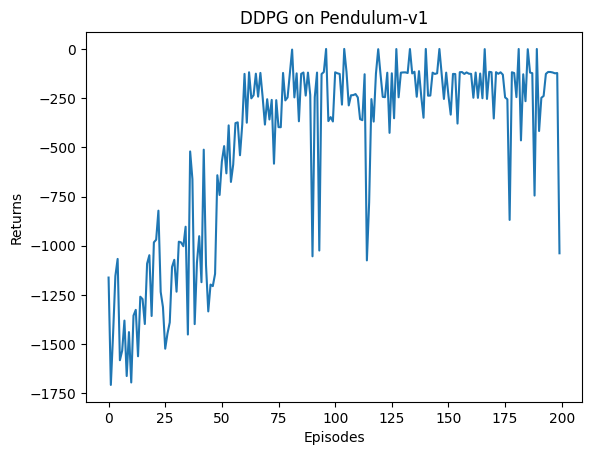

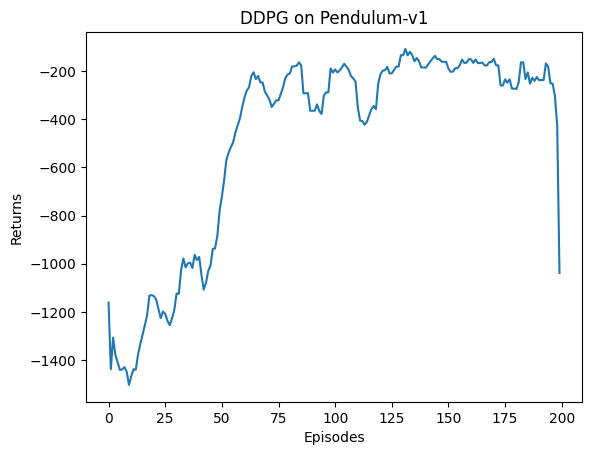

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

- 可以发现 DDPG 在倒立摆环境中表现出很不错的效果，其学习速度非常快，并且不需要太多样本。有兴趣的读者可以尝试自行调节超参数（例如用于探索的高斯噪声参数），观察训练结果的变化。

## 13.4 小结
- 本章讲解了深度确定性策略梯度算法（DDPG），它是面向连续动作空间的深度确定性策略训练的典型算法。相比于它的先期工作，即确定性梯度算法（DPG），DDPG 加入了目标网络和软更新的方法，这对深度模型构建的价值网络和策略网络的稳定学习起到了关键的作用。DDPG 算法也被引入了多智能体强化学习领域，催生了 MADDPG 算法，我们会在后续的章节中对此展开讨论。

## 13.5 扩展阅读：确定性策略梯度定理的证明
- 对于确定性策略 $\mu$，强化学习的目标函数可以写成期望的形式：

$$
J(\mu_\theta)=\int_\mathcal{S}\nu^{\mu_\theta}(s)r(s,\mu_\theta(s))\mathrm{d}s=\mathbb{E}_{s\sim\nu^{\mu_\theta}}[r(s,\mu_\theta(s))]
$$

- 其中，$\mathcal{S}$ 表示状态空间，$\nu$ 是第 3 章介绍过的状态访问分布。下面证明过程与策略梯度定理较为相似，可以对比阅读。

- 首先直接计算 $V^{\mu_{\theta}}$ 对 $\theta$ 的梯度。由于 $\mu_{\theta}$ 是确定性策略，因此 $V^{\mu_\theta}(s)=Q^{\mu_\theta}(s,\mu_\theta(s))$，进而可以给出如下推导：

$$
\begin{aligned}
\nabla_\theta V^{\mu_\theta}(s) & =\nabla_{\theta}Q^{\mu_{\theta}}(s,\mu_{\theta}(s)) \\
(\text{代入}Q) & =\nabla_\theta\left(r(s,\mu_\theta(s))+\int_\mathcal{S}\gamma p(s^{\prime}|s,\mu_\theta(s))V^{\mu_\theta}(s^{\prime})\mathrm{d}s^{\prime}\right) \\
(\text{第一项用链式法则}) & =\nabla_{\theta}\mu_{\theta}(s)\nabla_{a}r(s,a)|_{a=\mu_{\theta}(s)}+\nabla_{\theta}\int_{\mathcal{S}}\gamma p(s^{\prime}|s,\mu_{\theta}(s))V^{\mu_{\theta}}(s^{\prime})\mathrm{d}s^{\prime} \\
(\text{第二项用乘法法则}) & =\nabla_\theta\mu_\theta(s)\nabla_ar(s,a)|_{a=\mu_\theta(s)}+\int_S\gamma\left(p(s^{\prime}|s,\mu_\theta(s))\nabla_\theta V^{\mu_\theta}(s^{\prime})+\nabla_\theta\mu_\theta(s)\nabla_ap(s^{\prime}|s,a)|_{a=\mu_\theta(s)}V^{\mu_\theta}(s^{\prime})\right)\mathrm{d}s \\
(\text{合并同类项}) & =\nabla_{\theta}\mu_{\theta}(s)\nabla_{a}\left(r(s,a)+\int_{\mathcal{S}}\gamma p(s^{\prime}|s,a)V^{\mu_{\theta}}(s^{\prime})\mathrm{d}s^{\prime}\right)|_{a=\mu_{\theta}(s)}+\int_{\mathcal{S}}\gamma p(s^{\prime}|s,\mu_{\theta}(s))\nabla_{\theta}V^{\mu_{\theta}}(s^{\prime})\mathrm{d}s^{\prime} \\
 (\text{代回}Q) & =\nabla_\theta\mu_\theta(s)\nabla_aQ^{\mu_\theta}(s,a)|_{a=\mu_\theta(s)}+\int_\mathcal{S}\gamma p(s\to s^{\prime},1,\mu_\theta)\nabla_\theta V^{\mu_\theta}(s^{\prime})\mathrm{d}s^{\prime}
\end{aligned}
$$

- 至此我们仅进行了简单的链式求导、合并同类项和代换，下面重点对等式右边的积分进行处理。积分中出现的 $\nabla_{\theta}V^{\mu_{\theta}}(s^{\prime})$ 项正是等式左边要计算的 $\nabla_{\theta}V^{\mu_{\theta}}(s)$ 在状态 $s'$ 下的值，因此可以进行反复迭代：

$$
\begin{aligned}
\nabla_{\theta}V^{\mu_{\theta}}(s) & =\nabla_\theta\mu_\theta(s)\nabla_aQ^{\mu_\theta}(s,a)|_{a=\mu_\theta(s)}+\int_\mathcal{S}\gamma p(s\to s^{\prime},1,\mu_\theta)\nabla_\theta V^{\mu_\theta}(s^{\prime})\mathrm{d}s^{\prime} \\
(V^{\mu_\theta}(s^{\prime})\text{自我代入}) & =\nabla_\theta\mu_\theta(s)\nabla_aQ^{\mu_\theta}(s,a)|_{a=\mu_\theta(s)} \\
 & +\int_{\mathcal{S}}\gamma p(s\to s^{\prime},1,\mu_{\theta})\nabla_{\theta}\mu_{\theta}(s^{\prime})\nabla_{a}Q^{\mu_{\theta}}(s^{\prime},a)|_{a=\mu_{\theta}(s^{\prime})}\mathrm{d}s^{\prime} \\
 & +\int_{\mathcal{S}}\left(\gamma p(s\to s^{\prime},1,\mu_{\theta})\int_{\mathcal{S}}\gamma p(s^{\prime}\to s^{\prime\prime},1,\mu_{\theta})\nabla_{\theta}V^{\mu_{\theta}}(s^{\prime\prime})\mathrm{d}s^{\prime\prime}\right)\mathrm{d}s^{\prime} \\
(\text{按含义计算出积分}) & =\nabla_\theta\mu_\theta(s)\nabla_aQ^{\mu_\theta}(s,a)|_{a=\mu_\theta(s)} \\
 & +\int_{\mathcal{S}}\gamma p(s\to s^{\prime},1,\mu_\theta)\nabla_\theta\mu_\theta(s^{\prime})\nabla_aQ^{\mu_\theta}(s^{\prime},a)|_{a=\mu_\theta(s^{\prime})}\mathrm{d}s^{\prime} \\
 & +\int_{\mathcal{S}}\gamma^2p(s\to s^{\prime},2,\mu_\theta)\nabla_\theta V^{\mu_\theta}(s^{\prime})\mathrm{d}s^{\prime} \\
(\text{不断迭代}) & =\ldots \\
\text{(迭代结果)} & =\nabla_\theta\mu_\theta(s)\nabla_aQ^{\mu_\theta}(s,a)|_{a=\mu_\theta(s)} \\
 & +\int_{\mathcal{S}}\sum_{t=1}^{\infty}\gamma^{t}p(s\to s^{\prime},t,\mu_{\theta})\nabla_{\theta}\mu_{\theta}(s^{\prime})\nabla_{a}Q^{\mu_{\theta}}(s^{\prime},a)|_{a=\mu_{\theta}(s^{\prime})}\mathrm{d}s^{\prime} \\
(\text{第一项并入求和}) & =\int_{\mathcal{S}}\sum_{t=0}^\infty\gamma^tp(s\to s^{\prime},t,\mu_\theta)\nabla_\theta\mu_\theta(s^{\prime})\nabla_aQ^{\mu_\theta}(s^{\prime},a)|_{a=\mu_\theta(s^{\prime})}\mathrm{d}s^{\prime}
\end{aligned}
$$

- 这样就计算出了 $V^{\mu_{\theta}}$ 对 $\theta$ 的梯度。最终的优化目标累积回报函数 $J(\mu_{\theta})$ 的其中一种定义就是 $V(s)$ 按照初始状态的分布 $\mu_0(s)$ 对状态求期望：

$$
J(\mu_\theta)=\int_\mathcal{S}\nu_0(s)V^{\mu_\theta}(s)\mathrm{d}s
$$

- 计算 $J(\mu_{\theta})$ 对 $\theta$ 梯度并代入上面的结果，就得到：

$$
\begin{aligned}
 \nabla_\theta J(\mu_\theta) & =\nabla_\theta\int_\mathcal{S}\nu_0(s)V^{\mu_\theta}(s)\mathrm{d}s \\
 & =\int_{\mathcal{S}}\nu_0(s)\nabla_\theta V^{\mu_\theta}(s)\mathrm{d}s \\
 (\text{代入}V^{\mu_\theta}(s)) & =\int_{\mathcal{S}}\nu_0(s)\left(\int_{\mathcal{S}}\sum_{t=0}^\infty\gamma^tp(s\to s^{\prime},t,\mu_\theta)\nabla_\theta\mu_\theta(s^{\prime})\nabla_aQ^{\mu_\theta}(s^{\prime},a)|_{a=\mu_\theta(s^{\prime})}\mathrm{d}s^{\prime}\right)\mathrm{d}s \\
(\text{交换积分顺序}) & =\int_{\mathcal{S}}\left(\int_{\mathcal{S}}\sum_{t=0}^{\infty}\gamma^{t}\nu_{0}(s)p(s\to s^{\prime},t,\mu_{\theta})\mathrm{d}s\right)\nabla_{\theta}\mu_{\theta}(s^{\prime})\nabla_{a}Q^{\mu_{\theta}}(s^{\prime},a)|_{a=\mu_{\theta}(s^{\prime})}\mathrm{d}s^{\prime} \\
(\text{代回}\nu^{\mu_\theta}(s)) & =\int_{\mathcal{S}}\nu^{\mu_{\theta}}(s)\nabla_{\theta}\mu_{\theta}(s)\nabla_{a}Q^{\mu_{\theta}}(s^{\prime},a)|_{a=\mu_{\theta}(s^{\prime})}\mathrm{d}s \\
 & =\mathbb{E}_{s\sim\nu^{\mu_\theta}}[\nabla_\theta\mu_\theta(s)\nabla_aQ^{\mu_\theta}(s^{\prime},a)|_{a=\mu_\theta(s^{\prime})}].
\end{aligned}
$$

- 以上过程证明的是在线策略形式的 DPG 定理，期望下标明确表示 $s \sim \mu^{\mu_{\theta}}$。为了得到离线策略形式的 DPG 定理，我们只需要将目标函数写成 $J(\theta)=\int_{\mathcal{S}}\nu^{\beta}V^{\mu_{\theta}}(s)\mathrm{d}s=\int_{\mathcal{S}}\nu^{\beta}Q^{\mu_{\theta}}(s,\mu_{\theta}(s))\mathrm{d}s$，然后进行求导即可。